In [5]:
import numpy as np
from pr3_utils import *
from stereo import *

### load data

In [6]:
dataset = "10"
time_stamp,features,linear_velocity,angular_velocity,K,b,imu_T_cam = load_data(f"../data/{dataset}.npz")

### motion model to get trajectory

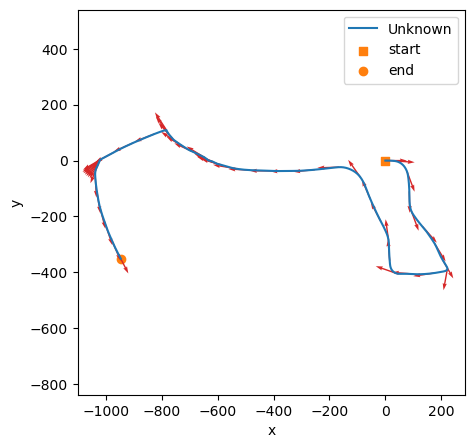

(<Figure size 500x500 with 1 Axes>, <Axes: xlabel='x', ylabel='y'>)

In [7]:
tau = time_stamp[1:] - time_stamp[:-1]
velocity = np.concatenate([linear_velocity, angular_velocity], axis=1)
T = np.zeros([time_stamp.shape[0],4,4])
T[0,:,:] = np.array([
    [1, 0, 0,0],
    [0, 1, 0,0],
    [0, 0, 1,0],
    [0, 0, 0,1],
])
for t in range(1, time_stamp.shape[0]):
    T[t,:,:] = T[t-1,:,:] @ twist2pose(tau[t-1]*axangle2twist(velocity[t]))
visualize_trajectory(T, show_ori=True)

In [8]:
# np.save(f"../data/motion_trj_{dataset}",T)
# T = np.load(f"../data/motion_trj_{dataset}.npy")
# T.shape

### pre-compute all feature init values

In [9]:
seen_mask = np.zeros(features.shape[1], dtype=bool)
features_init = np.zeros([features.shape[1], 3])

for t in range(time_stamp.shape[0]):
    PC_camera, present_mask = features_to_PC_camera(features[t], K, b)
    PC_camera_hom = np.hstack([PC_camera, np.ones([PC_camera.shape[0],1])])
    PC_world_hom  = (T[t] @ imu_T_cam @ PC_camera_hom.T).T
    PC_world = PC_world_hom[:,:3]

    first_time_mask = np.logical_and((np.logical_not(seen_mask)), present_mask)
    features_init[first_time_mask] = PC_world[first_time_mask]

    seen_mask[first_time_mask] = True
    if np.all(seen_mask):
        print(f"seen all features at {t} stamp")
        break

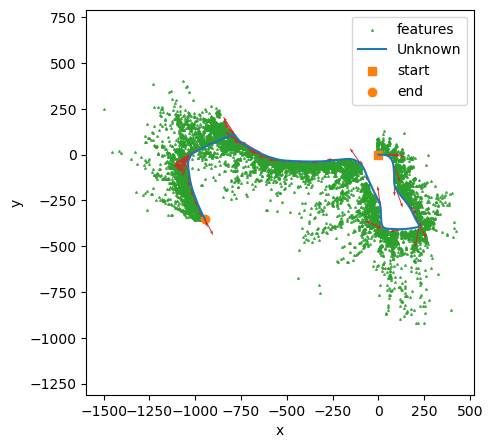

In [10]:
fig, ax = visualize_trajectory(T, features=features_init,show_ori=True)
plt.show()

In [11]:
np.save(f"../data/feature_init_{dataset}",T)
# features_init = np.load(f"../data/feature_init__{dataset}.npy")
# features_init.shape